In [2]:
# Load package
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
sns.set(font_scale=2) 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from PIL import Image
from torchsummary import summary

# Data
df = pd.read_pickle("./LSWMD.pkl")
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [7]:
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1

df_withlabel = df.drop(['waferIndex','dieSize','lotName', 'trianTestLabel'], axis = 1)
df_withlabel = df_withlabel[(df_withlabel['failureType']!=0)]
df_withlabel['waferMapDim']= df_withlabel['waferMap'].apply(lambda x: find_dim(x))
sub_df = df_withlabel.loc[df_withlabel['waferMapDim'] == (25, 27)]
sub_df.head()

C:\Users\lemon\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,waferMap,failureType,waferMapDim
16409,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1,...",[[Edge-Loc]],"(25, 27)"
16432,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1,...",[[Edge-Loc]],"(25, 27)"
16455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1,...",[[Edge-Loc]],"(25, 27)"
22785,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",[[Edge-Loc]],"(25, 27)"
22787,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",[[Edge-Loc]],"(25, 27)"


In [74]:
sub_df_2 = sub_df.loc[sub_df['failureType'] == 'Edge-Ring']
one_data = sub_df_2.head(1)
one_data.head()

,waferMap,failureType,waferMapDim
512944,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",[[Edge-Ring]],"(25, 27)"


In [75]:
wafer_map_2d = sub_df_2.loc[512944, 'waferMap']
failure_type = sub_df_2.loc[512944, 'failureType']

In [76]:
wafer_map_2d

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2,
        2, 2, 0, 0, 0],
       [0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1,
        2, 2, 2, 0, 0],
       [0, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 2, 2, 0, 0],
       [0, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 2, 2, 2, 0],
       [0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 0],
       [0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 2, 2, 1, 2],
       [0, 2, 1, 1, 

In [77]:
failure_type[0][0]

'Edge-Ring'

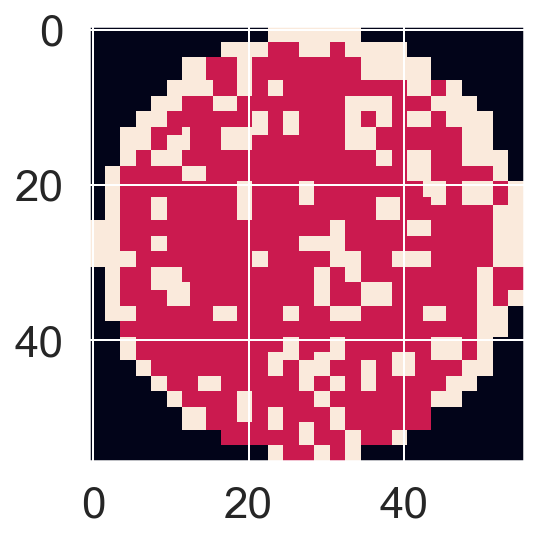

In [78]:
import torch
import numpy as np
from PIL import Image

def process_data(wafer_map, failure_type, device, target_dim=(56, 56)):
    processed_tensor = torch.ones((1, *target_dim, 3), device=device)
    labels = []

    # Convert wafer_map to a tensor and move it to the specified device (e.g., CUDA)
    wafer_map = torch.tensor(wafer_map, dtype=torch.float32).unsqueeze(0).to(device)
    Dim0, Dim1 = wafer_map.shape[1], wafer_map.shape[2]

    # Create an RGB wafer map with dimensions (1, Dim0, Dim1, 3)
    rgb_wafer_map = torch.zeros((1, Dim0, Dim1, 3), device=device)
    for h in range(Dim0):
        for w in range(Dim1):
            rgb_wafer_map[0, h, w, int(wafer_map[0, h, w])] = 1

    # Convert the tensor to a numpy array and resize it
    rgb_np = rgb_wafer_map.squeeze(0).cpu().numpy().astype('uint8')
    resized = Image.fromarray(rgb_np).resize(target_dim)
    resized_np = np.array(resized).reshape((1, *target_dim, 3))
    resized_tensor = torch.from_numpy(resized_np).to(device)

    # Concatenate the resized tensor to the processed tensor
    processed_tensor = torch.cat([processed_tensor, resized_tensor])
    labels.append(failure_type[0][0])
    
    # Remove the initial dummy tensor
    final_tensor = processed_tensor[1:]
    labels = np.array(labels).reshape((-1, 1))

    return final_tensor, labels

# Example usage
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# Assuming wafer_map_2d and failure_type are defined
final_tensor, labels = process_data(wafer_map_2d, failure_type, DEVICE)

# show Image
plt.imshow(torch.argmax(final_tensor[0],axis=2).cpu().numpy())
plt.show()

In [49]:
loaded_model = torch.jit.load('./cnn_model_scripted.pt')
loaded_model.to('cuda')
print(loaded_model)

RecursiveScriptModule(
  original_name=CNN
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (layer2): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (layer3): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (fc1): RecursiveScriptModule(original_name=Linear)
  (layer4): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
  )
  (fc2): RecursiveScriptModule(original_name=Lin

In [79]:
test_tensor_data = final_tensor.permute(0,3,1,2).contiguous()
print(test_tensor_data.shape)
output = loaded_model(test_tensor_data)

torch.Size([1, 3, 56, 56])


In [80]:
# Assume `output` is the tensor returned by the model
# If the output is class scores, use argmax to get the predicted class
predicted_classes = torch.argmax(output, dim=1)

# Convert to a NumPy array
predicted_classes_np = predicted_classes.cpu().numpy()

# Or convert to a Python list
predicted_classes_list = predicted_classes.cpu().tolist()

# Now `predicted_classes_np` or `predicted_classes_list` contains the integer class predictions
print(predicted_classes_np)  # Prints array of integers
print(predicted_classes_list)  # Prints list of integers

[3]
[3]
